## Overview
In the experimental, I show how to build a recommand model for Movie Recommendation based on MovieLens 100K data set.
MovieLens data sets were collected over various periods of time, depending on the size of the set. MovieLens 100K movie ratings. Stable benchmark dataset. 100,000 ratings from 1000 users on 1700 movies. Released on 4/1998.

## Setup
Let's first install necessary libraries and get our imports out of the way.

In [1]:
!pip install --upgrade tensorflow-datasets tensorflow-recommenders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 32.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.2/96.2 kB 9.1 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-datasets
    Found existing installation: tensorflow-datasets 4.9.2
    Uninstalling tensorflow-datasets-4.9.2:
      Successfully uninstalled tensorflow-datasets-4.9.2


In [2]:
from typing import Dict, Text

import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs
import matplotlib.pyplot as plt
import keras_tuner as kt
from sklearn.model_selection import train_test_split

## Preparing the dataset

Thanks to Tensorflow datasets, I could load the dataset directly by its api, it provides a snapshot on the Internet. After I call the api, it downloads, processes the dataset and returns a tensorflow dataset object.

In [3]:
ratings = tfds.load("movielens/100k-ratings", split="train")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/100000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/movielens/100k-ratings/0.1.1.incompleteXED0G4/movielens-train.tfrecord*...…

Dataset movielens downloaded and prepared to /root/tensorflow_datasets/movielens/100k-ratings/0.1.1. Subsequent calls will reuse this data.


For convinence, I convert the dataset to a pandas dataframe format for visualing dataset. Since pandas requires the columns must be same dimension, I convert movie genres to string format, which is array format before converted.

In [4]:
def replace_genres(x):
    # merge multi values to one value in order to convert tf dataset to dataframe
    x['movie_genres'] = tf.strings.reduce_join(tf.strings.as_string(x['movie_genres']), axis=-1, separator='_')
    return x
pd_ds = ratings.map(replace_genres).batch(100000)
train_dict = next(iter(pd_ds))
df = pd.DataFrame.from_dict(train_dict)

Let’s view processed dataframe base information by ```info``` and ```head```. According to ```info```, there are 100000 samples without null object in the dataset.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   bucketized_user_age    100000 non-null  float32
 1   movie_genres           100000 non-null  object 
 2   movie_id               100000 non-null  object 
 3   movie_title            100000 non-null  object 
 4   raw_user_age           100000 non-null  float32
 5   timestamp              100000 non-null  int64  
 6   user_gender            100000 non-null  bool   
 7   user_id                100000 non-null  object 
 8   user_occupation_label  100000 non-null  int64  
 9   user_occupation_text   100000 non-null  object 
 10  user_rating            100000 non-null  float32
 11  user_zip_code          100000 non-null  object 
dtypes: bool(1), float32(3), int64(2), object(6)
memory usage: 7.3+ MB


As ```head``` function shows, there are several class features such as ```user_occupation_text```, ```movie_genres```, ```movie_id``` and ```user_zip_code```. I have to convert them to int features by ```StringLookup``` or ```IntegerLookup``` for training the model.

In [6]:
df.head()

,bucketized_user_age,movie_genres,movie_id,movie_title,raw_user_age,timestamp,user_gender,user_id,user_occupation_label,user_occupation_text,user_rating,user_zip_code
0,45.0,b'7',b'357',"b""One Flew Over the Cuckoo's Nest (1975)""",46.0,879024327,True,b'138',4,b'doctor',4.0,b'53211'
1,25.0,b'4_14',b'709',b'Strictly Ballroom (1992)',32.0,875654590,True,b'92',5,b'entertainment',2.0,b'80525'
2,18.0,b'4',b'412',"b'Very Brady Sequel, A (1996)'",24.0,882075110,True,b'301',17,b'student',4.0,b'55439'
3,50.0,b'5_7',b'56',b'Pulp Fiction (1994)',50.0,883326919,True,b'60',4,b'healthcare',4.0,b'06472'
4,50.0,b'10_16',b'895',b'Scream 2 (1997)',55.0,891409199,True,b'197',18,b'technician',3.0,b'75094'


In order to display time infomation in a normal format, I convert timestamp to datetime format.

In [7]:
def to_datetime(x):
    x['year_month'] = datetime.fromtimestamp(x['timestamp']).strftime("%Y-%m")
    return x
df = df.apply(to_datetime, axis=1)

The plot shows rating counts in different months.

<Axes: xlabel='year_month'>

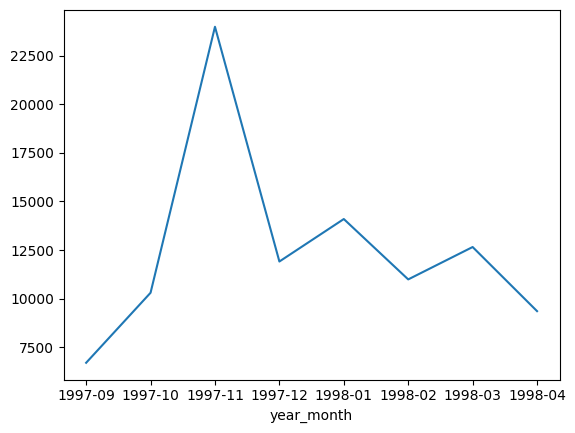

In [8]:
df['year_month'].value_counts().sort_index().plot(kind='line')

The bar chart shows rating values are always integers and 4 is most common rating value.

<Axes: xlabel='user_rating'>

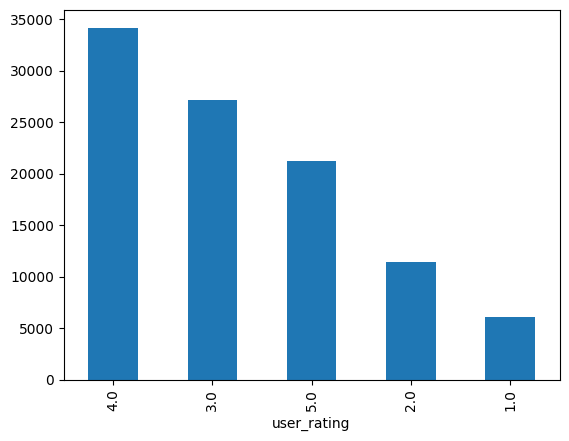

In [9]:
df['user_rating'].value_counts().plot(kind='bar')

The bar chart shows relationship between different occupation and rating counts.

<Axes: xlabel='user_occupation_text'>

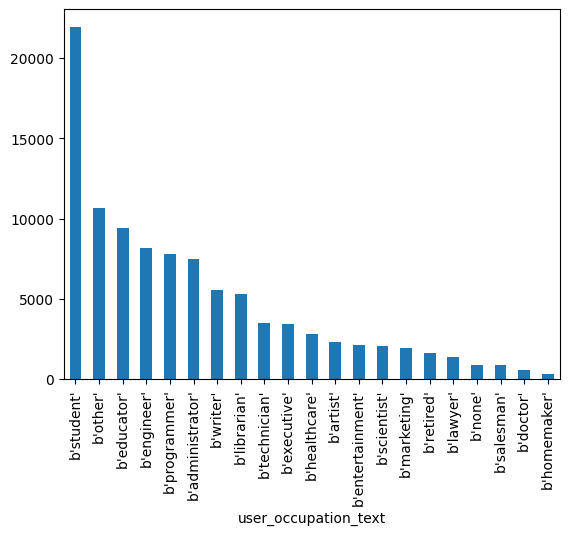

In [10]:
df['user_occupation_text'].value_counts().plot(kind='bar')

The majority of users who rates movies are between 25-34.
There are age ranges of different bucketized user ages.

1: "Under 18"

18: "18-24"

25: "25-34"

35: "35-44"

45: "45-49"

50: "50-55"

56: "56+"

<Axes: xlabel='bucketized_user_age'>

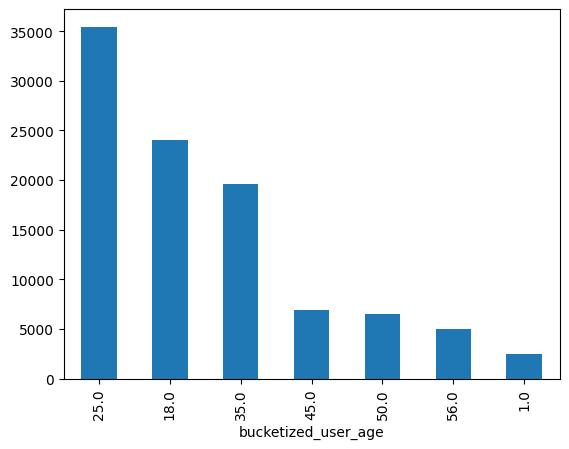

In [11]:
df['bucketized_user_age'].value_counts().plot(kind='bar')

The plot shows the relationship between rating number and rating means on different movies.

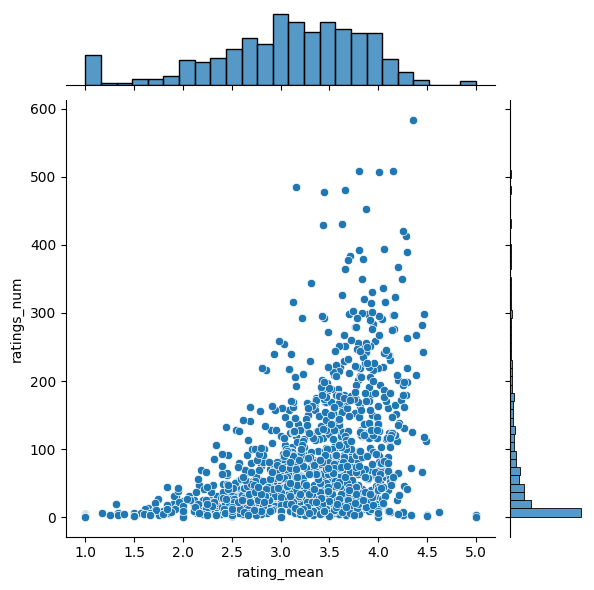

In [12]:
ratings_joint = pd.DataFrame()
ratings_joint["rating_mean"] = df.groupby("movie_title")['user_rating'].mean()
ratings_joint['ratings_num'] = df.groupby("movie_title")["user_rating"].count()
sns.jointplot(x='rating_mean', y='ratings_num', data=ratings_joint)

I also draw a correlation matrix helps me to select useful features. According to heatmap, these features have similar importance. 

<Axes: >

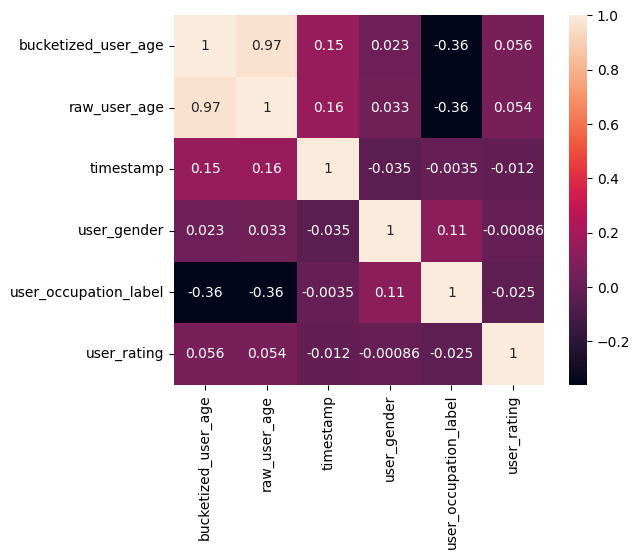

In [13]:
sns.heatmap(df.corr(numeric_only=True), square=True, annot=True)

I select 80000 samples as train dataset and 20000 samples as test dataset. In order to get same output shape of different rows, I convert movie genres, array like feature, to a multi hot feature, each row has same output shape which correspond to movie genres class count plus 1. 

In [14]:
num_tokens = df['movie_genres'].apply(lambda x: x.decode('utf-8').split('_')).explode(ignore_index=True).nunique()
movie_genres_encoder = tf.keras.layers.CategoryEncoding(num_tokens=num_tokens+1, output_mode="multi_hot")

def preprocess(x):
    x["movie_genres"] = movie_genres_encoder(x["movie_genres"])
    x["user_gender"] = tf.cast(x["user_gender"], tf.float32)
    return x

ratings = ratings.map(preprocess)

shuffled = ratings.shuffle(100000, reshuffle_each_iteration=False)

train = shuffled.take(80000)
test = shuffled.skip(80000).take(20000)

train_dataset = train.batch(1024).shuffle(10000).cache()
test_dataset = test.batch(1024).cache()

## Implementing a simple model

In the first approach, I employ user zip codes, movie genres, user gender, user age and user occupation label as inputs, some inputs follow an embedding layer in order to reduce output dimensions. Finally I concat these features into a tensor and put them into a MLP, which predicts rating values. Since sigmoid produce float values but the labels is integer values, so I round these values to nearest integer, then I clip these values in range 0 and 5 to ensure the model outputs correct values when the model is doing inference.

In the following steps, I use ```StringLoopup``` and ```IntegerLookup```  translates a set of arbitrary values into contiguous ranges.

In [15]:
unique_movie_ids = tf.keras.layers.StringLookup(vocabulary=df["movie_id"].unique(), mask_token=None, num_oov_indices=0)
unique_user_zip_codes = tf.keras.layers.StringLookup(vocabulary=df["user_zip_code"].unique(), mask_token=None, num_oov_indices=0)
unique_occupation_label = tf.keras.layers.IntegerLookup(vocabulary=df["user_occupation_label"].unique(), mask_token=None, num_oov_indices=0)

I do following steps in order to get an initial value that is used in a embedding which could gain movie genres from movie ids.

In [16]:
movie_group = df.groupby("movie_id")
movie_group = pd.DataFrame(
    data={
        "movie_id": movie_group.movie_id.first(),
        "movie_genres": movie_group.movie_genres.first(),
    }
)

# split string value to multi values.
movie_group["movie_genres"] = movie_group['movie_genres'].apply(lambda x: x.decode('utf-8').split('_'))
genres = movie_group["movie_genres"].explode(ignore_index=True).unique()
for genre in genres:
    movie_group[genre] = movie_group["movie_genres"].apply(
        lambda values: int(genre in values)
    )
movie_genres_multi_hot = movie_group[genres].to_numpy()

This is a base model, the majority part of the model without training related codes.

In [17]:
class RankingModel(tf.keras.Model):

    def __init__(self, dense_unit=512, embedding_dimension=32, using_user_zip_codes=True, using_movie_genres=True, using_user_occupation_label=True, using_user_gender=True, using_user_age=True):
        super().__init__()
        # Tunable hyperparamters to determine whether use these features
        self.using_user_zip_codes = using_user_zip_codes
        self.using_movie_genres = using_movie_genres
        self.using_user_occupation_label = using_user_occupation_label
        self.using_user_gender = using_user_gender
        self.using_user_age = using_user_age
        
        # Compute embeddings for users.
        self.user_zip_code_embeddings = tf.keras.Sequential([
            unique_user_zip_codes,
            tf.keras.layers.Embedding(unique_user_zip_codes.vocabulary_size() + 1, embedding_dimension)
        ], name="user_zip_code_embeddings")

        # Compute embeddings for movies.
        self.movie_embeddings = tf.keras.layers.Embedding(unique_movie_ids.vocabulary_size() + 1, embedding_dimension, name="movie_embeddings")
        
        # Get movie genres by movie id
        self.movie_genres_embeddings = tf.keras.layers.Embedding(
            input_dim=movie_genres_multi_hot.shape[0],
            output_dim=movie_genres_multi_hot.shape[1],
            embeddings_initializer=tf.keras.initializers.Constant(movie_genres_multi_hot),
            trainable=False,
            name="movie_genres_embeddings",
        )
        # Compute embeddings for user occupation
        self.user_occupation_label_embeddings = tf.keras.Sequential([
            unique_occupation_label,
            tf.keras.layers.Embedding(unique_occupation_label.vocabulary_size() + 1, 8)
        ], name="user_occupation_label_embeddings")

        # Compute predictions.
        self.ratings = tf.keras.Sequential([
            # Learn multiple dense layers.
            tf.keras.layers.Dense(dense_unit, activation="relu"),
            tf.keras.layers.Dense(dense_unit//4, activation="relu"),
            # Make rating predictions in the final layer.
            tf.keras.layers.Dense(1)
        ], name="ratings")

    def call(self, inputs, training=False):

        user_zip_code, movie_id, user_age, user_occupation_label, user_gender = inputs
        
        features = []
        # Add user zip code embedding into features
        if self.using_user_zip_codes:
            features.append(self.user_zip_code_embeddings(user_zip_code))
        movie_id = unique_movie_ids(movie_id)
        features.append(self.movie_embeddings(movie_id))
        # Add movie genres embedding into features
        if self.using_movie_genres:
            features.append(self.movie_genres_embeddings(movie_id))
        # Add movie genres embedding into features
        if self.using_user_occupation_label:
            features.append(self.user_occupation_label_embeddings(user_occupation_label))
        # Add user gender into features, Here I use 0 and 1 represent male and female.
        if self.using_user_gender:
            features.append(tf.expand_dims(user_gender, axis=-1))
        # Add bucketized user age into features directly.
        if self.using_user_age:
            features.append(tf.expand_dims(user_age, axis=-1))

        res = tf.squeeze(self.ratings(tf.concat(features, axis=1)), axis=-1)
        # return floats in training mode otherwise return integers in inference mode.
        return res if training else tf.clip_by_value(tf.math.round(res), 0, 5)

Test model with a sample.

In [18]:
example = next(iter(train_dataset))
ranking_model = RankingModel()
ranking_model((example["user_zip_code"], example["movie_id"], example["bucketized_user_age"], example["user_occupation_label"], example["user_gender"]))

<tf.Tensor: shape=(1024,), dtype=float32, numpy=array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)>

Let's print model parameters and shapes via ```summary```. There are total 225,351 parameters in the model, 193393 parameters are trainable and 31958 parameters are non-trainable.

In [19]:
ranking_model.summary(expand_nested=True)

Model: "ranking_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 user_zip_code_embeddings (S  (1024, 32)               25472     
 equential)                                                      
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| string_lookup_1 (StringLook  (1024,)                0         |
| up)                                                           |
|                                                               |
| embedding (Embedding)     (1024, 32)                25472     |
¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯
 movie_embeddings (Embedding  multiple                 53856     
 )                                                               
                                                                 
 movie_genres_embeddings (Em  multiple                 31958     
 bedding)                                            

Here is full training model which contains base model and training parts. In the model, I use MSE as loss and RMSE as metric.

In [49]:
class MovielensModel(tfrs.models.Model):
    def __init__(self, dense_units=512, embedding_dimension=32, using_user_zip_codes=True, using_movie_genres=True, using_user_occupation_label=True, using_user_gender=True, using_user_age=True):
        super().__init__()
        # Model Arch
        self.ranking_model: tf.keras.Model = RankingModel(dense_units, embedding_dimension, using_user_zip_codes, using_movie_genres, using_user_occupation_label, using_user_gender, using_user_age)
        # Ranking class helps with building ranker models. Usually, these will involve predicting signals such as clicks, cart additions, likes, ratings, and purchases.
        self.task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
          loss = tf.keras.losses.MeanSquaredError(),
          metrics=[tf.keras.metrics.RootMeanSquaredError()]
        )

    def call(self, features: Dict[str, tf.Tensor]) -> tf.Tensor:
        return self.ranking_model(
            (features["user_zip_code"], features["movie_id"], features["bucketized_user_age"], features["user_occupation_label"], features["user_gender"]))

    def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
        labels = features.pop("user_rating")

        rating_predictions = self(features, training=training)
        # Computes the task loss and metrics.
        return self.task(labels=labels, predictions=rating_predictions)

Let's first instantiate the model. Here I employ Adagrad as optimizer. Adaptive Gradient algorithm, or AdaGrad for short, keeps track of the sum of gradient squared and uses that to adapt the gradient in different directions. Often the equations are expressed in tensors. I will avoid tensors to simplify the language here. For each dimension:

sum_of_gradient_squared = previous_sum_of_gradient_squared + gradient²

delta = -learning_rate * gradient / sqrt(sum_of_gradient_squared)

theta += delta

![image](https://miro.medium.com/v2/resize:fit:720/1*WRtvrr9Z0QcokiKlgU7xEw.gif)

In [54]:
def build_model(learning_rate=0.1, dense_units=512, embedding_dimension=32, using_user_zip_codes=True, using_movie_genres=True, using_user_occupation_label=True, using_user_gender=True, using_user_age=True):
    model = MovielensModel(dense_units, embedding_dimension, using_user_zip_codes, using_movie_genres, using_user_occupation_label, using_user_gender, using_user_age)
    model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=learning_rate))
    model.build(tf.nest.map_structure(lambda x: x.shape, example))
    return model

model = build_model()

Train the  model 10 epochs.

In [51]:
history = model.fit(train_dataset, epochs=10, validation_data=test_dataset)

Epoch 1/10
79/79 [==============================] - 9s 96ms/step - root_mean_squared_error: 44.6553 - loss: 1947.4008 - regularization_loss: 0.0000e+00 - total_loss: 1947.4008 - val_root_mean_squared_error: 1.2653 - val_loss: 1.7408 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.7408
Epoch 2/10
79/79 [==============================] - 0s 6ms/step - root_mean_squared_error: 1.1451 - loss: 1.3100 - regularization_loss: 0.0000e+00 - total_loss: 1.3100 - val_root_mean_squared_error: 1.1465 - val_loss: 1.3566 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.3566
Epoch 3/10
79/79 [==============================] - 0s 6ms/step - root_mean_squared_error: 1.0834 - loss: 1.1728 - regularization_loss: 0.0000e+00 - total_loss: 1.1728 - val_root_mean_squared_error: 1.0966 - val_loss: 1.2996 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.2996
Epoch 4/10
79/79 [==============================] - 0s 6ms/step - root_mean_squared_error: 1.0415 - loss: 1.0835 - regularizatio

Let's plot training logs, according to the plot, the model is underfitting and I should train the model with more epochs.

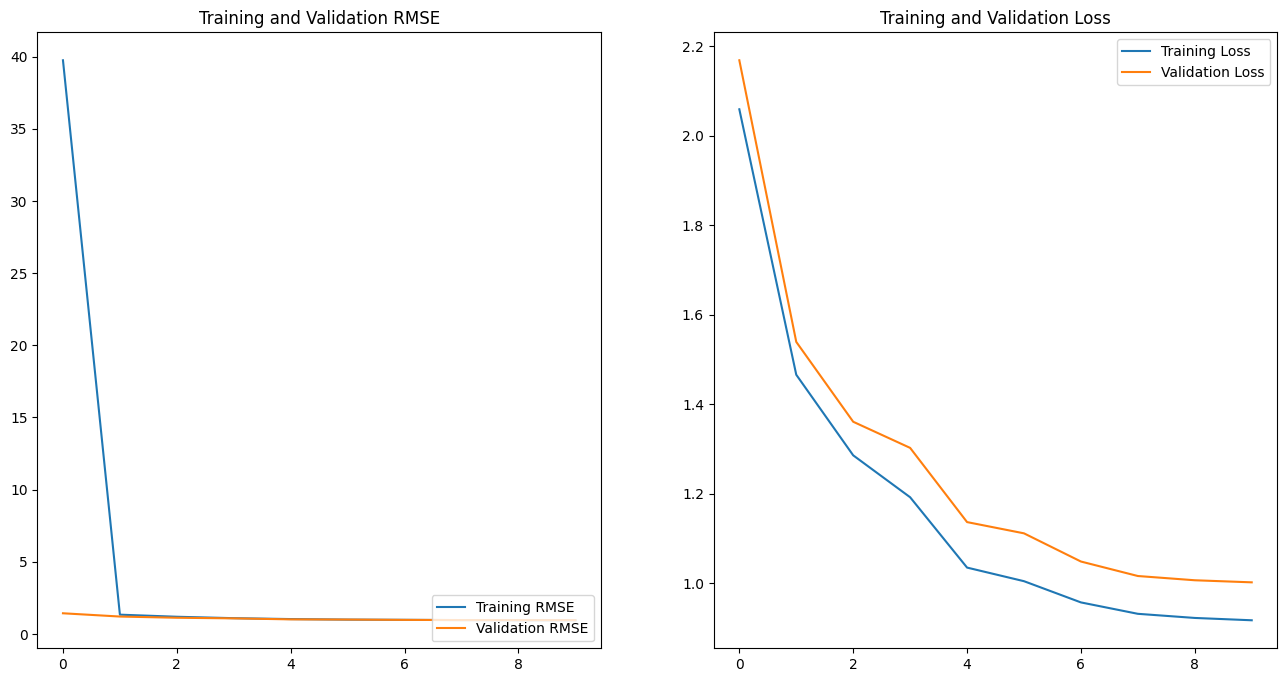

In [23]:
rmse = history.history['root_mean_squared_error']
val_rmse = history.history['val_root_mean_squared_error']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(loss))

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, rmse, label='Training RMSE')
plt.plot(epochs_range, val_rmse, label='Validation RMSE')
plt.legend(loc='lower right')
plt.title('Training and Validation RMSE')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Implementing a transformer model

In the approach, I try to explore the timestamp usage in the dataset. I set 4 movie ids and 4 user ratings as sequences, predicting last value from previous three values. I add transformer as a sequence encoder then put transformer outputs into a MLP. The rest parts are similar to the simple model. 

Before train the model, I preprocess the dataset and add two new features, ```sequence_user_ratings``` and ```sequence_movie_ids```. Firstly, I sort the dataset by timestamp and group the dataset by user id.

In [24]:
ratings_group = df.sort_values(by=["timestamp"]).groupby("user_id")
ratings_data = pd.DataFrame(
    data={
        "user_id": list(ratings_group.groups.keys()),
        "movie_ids": list(ratings_group.movie_id.apply(list)),
        "user_ratings": list(ratings_group.user_rating.apply(list)),
        "timestamps": list(ratings_group.timestamp.apply(list)),
        "user_zip_code": ratings_group.user_zip_code.first(),
        "user_gender": ratings_group.user_gender.first(),
        "bucketized_user_age": ratings_group.bucketized_user_age.first(),
        "user_occupation_label": ratings_group.user_occupation_label.first()
    }
)


In the current implementation, I set sequence length is 4 and step size is 2.

In [25]:
sequence_length = 4
step_size = 2

def create_sequences(values, window_size, step_size):
    sequences = []
    start_index = 0
    while True:
        end_index = start_index + window_size
        seq = values[start_index:end_index]
        if len(seq) < window_size:
            seq = values[-window_size:]
            if len(seq) == window_size:
                sequences.append(seq)
            break
        sequences.append(seq)
        start_index += step_size
    return sequences

def create_sequences_fn(row):
    row['movie_ids'] = create_sequences(row['movie_ids'], sequence_length, step_size)
    row['user_ratings'] = create_sequences(row['user_ratings'], sequence_length, step_size)
    return row

ratings_data = ratings_data.apply(create_sequences_fn, axis=1)

Expand movie ids in first dimension, each row only has a movie ids array which contains 4 movie ids.

In [26]:
ratings_data_movies = ratings_data[["user_id", "movie_ids"]].explode("movie_ids", ignore_index=True)
ratings_data_rating = ratings_data[["user_ratings"]].explode("user_ratings", ignore_index=True)

ratings_data_transformed = pd.concat([ratings_data_movies, ratings_data_rating], axis=1)
ratings_data_transformed = ratings_data_transformed.join(ratings_data.set_index("user_id"), on="user_id", rsuffix='_')

ratings_data_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49760 entries, 0 to 49759
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                49760 non-null  object 
 1   movie_ids              49760 non-null  object 
 2   user_ratings           49760 non-null  object 
 3   movie_ids_             49760 non-null  object 
 4   user_ratings_          49760 non-null  object 
 5   timestamps             49760 non-null  object 
 6   user_zip_code          49760 non-null  object 
 7   user_gender            49760 non-null  bool   
 8   bucketized_user_age    49760 non-null  float64
 9   user_occupation_label  49760 non-null  int64  
dtypes: bool(1), float64(1), int64(1), object(7)
memory usage: 3.5+ MB


In [27]:
ratings_data_transformed.head()

,user_id,movie_ids,user_ratings,movie_ids_,user_ratings_,timestamps,user_zip_code,user_gender,bucketized_user_age,user_occupation_label
0,b'1',"[b'172', b'168', b'165', b'156']","[5.0, 5.0, 5.0, 4.0]","[[b'172', b'168', b'165', b'156'], [b'165', b'...","[[5.0, 5.0, 5.0, 4.0], [5.0, 4.0, 5.0, 5.0], [...","[874965478, 874965478, 874965518, 874965556, 8...",b'85711',True,18.0,18
1,b'1',"[b'165', b'156', b'166', b'196']","[5.0, 4.0, 5.0, 5.0]","[[b'172', b'168', b'165', b'156'], [b'165', b'...","[[5.0, 5.0, 5.0, 4.0], [5.0, 4.0, 5.0, 5.0], [...","[874965478, 874965478, 874965518, 874965556, 8...",b'85711',True,18.0,18
2,b'1',"[b'166', b'196', b'187', b'250']","[5.0, 5.0, 4.0, 4.0]","[[b'172', b'168', b'165', b'156'], [b'165', b'...","[[5.0, 5.0, 5.0, 4.0], [5.0, 4.0, 5.0, 5.0], [...","[874965478, 874965478, 874965518, 874965556, 8...",b'85711',True,18.0,18
3,b'1',"[b'187', b'250', b'127', b'14']","[4.0, 4.0, 5.0, 5.0]","[[b'172', b'168', b'165', b'156'], [b'165', b'...","[[5.0, 5.0, 5.0, 4.0], [5.0, 4.0, 5.0, 5.0], [...","[874965478, 874965478, 874965518, 874965556, 8...",b'85711',True,18.0,18
4,b'1',"[b'127', b'14', b'181', b'117']","[5.0, 5.0, 5.0, 3.0]","[[b'172', b'168', b'165', b'156'], [b'165', b'...","[[5.0, 5.0, 5.0, 4.0], [5.0, 4.0, 5.0, 5.0], [...","[874965478, 874965478, 874965518, 874965556, 8...",b'85711',True,18.0,18


I split dataset into two parts, training dataset has 80% samples and test dataset has 20% samples.

In [28]:
train, test = train_test_split(ratings_data_transformed.drop(columns=["movie_ids_", "user_ratings_"]), test_size=0.2)

In [29]:
def data_gen(df):
    def _exec():
        for (idx, row) in df.iterrows():
            yield (row["user_id"], row["movie_ids"], row["user_ratings"], row["user_zip_code"], row["user_gender"], row["bucketized_user_age"], row["user_occupation_label"])
        
    return _exec
transformer_train_dataset = tf.data.Dataset.from_generator(data_gen(train),
                                                           output_types=(tf.string, tf.string, tf.float32, tf.string, tf.bool, tf.float32, tf.int32),
                                                           output_shapes=((), (4), (4), (), (), (), ()))
transformer_test_dataset = tf.data.Dataset.from_generator(data_gen(test),
                                                          output_types=(tf.string, tf.string, tf.float32, tf.string, tf.bool, tf.float32, tf.int32),
                                                          output_shapes=((), (4), (4), (), (), (), ()))

Split last value from sequence and set it as target value.

In [30]:
def preprocess(user_id, movie_ids, user_ratings, user_zip_code, user_gender, bucketized_user_age, user_occupation_label):
    return {
        "user_id": user_id,
        # split sequence and target
        "sequence_movie_ids": movie_ids[:, :-1],
        "target_movie_id": movie_ids[:, -1],
        # split sequence and target
        "sequence_user_ratings": user_ratings[:, :-1],
        "user_rating": user_ratings[:, -1],
        "user_zip_code": user_zip_code,
        "user_gender": user_gender,
        "bucketized_user_age": bucketized_user_age,
        "user_occupation_label": user_occupation_label,
    }

transformer_train_dataset = transformer_train_dataset.cache().prefetch(1024).batch(1024).map(preprocess)
transformer_test_dataset = transformer_test_dataset.cache().prefetch(1024).batch(1024).map(preprocess)

Reference Behavior Sequence Transformer (BST) transformer implementation.

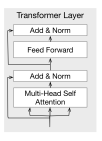

In [36]:
class Transformer(tf.keras.layers.Layer):
    def __init__(self, dropout_rate):
        # Set 41 in order to keep same shape as inputs for following add operator
        super().__init__()
        self.attention = tf.keras.layers.MultiHeadAttention(num_heads=3, key_dim=41, dropout=dropout_rate)
        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.norm1 = tf.keras.layers.LayerNormalization()
        # Set 41 in order to keep same shape as inputs for following add operator
        self.dense = tf.keras.layers.Dense(41)
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)
        self.norm2 = tf.keras.layers.LayerNormalization()
    
    def call(self, transformer_features):
        attention_output = self.attention(transformer_features, transformer_features)
        attention_output = self.dropout1(attention_output)
        x1 = tf.keras.layers.add([transformer_features, attention_output])
        x1 = self.norm1(x1)
        x2 = tf.nn.leaky_relu(x1)
        x2 = self.dense(x2)
        x2 = self.dropout2(x2)
        transformer_features = tf.keras.layers.add([x1, x2])
        transformer_features = self.norm2(transformer_features)
        return transformer_features

The model implementation with transformer. In order to prevent model from overfitting, I add some dropout layers in the model.
Here is a photo about model arch:

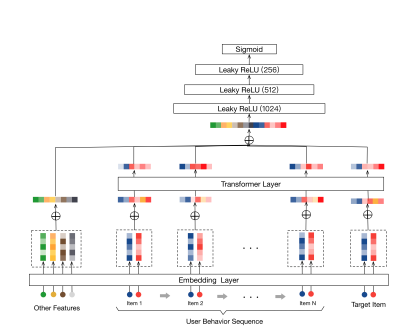

In [39]:
 class RankingTransformer(tf.keras.Model):

    def __init__(self):
        super().__init__()
        self.embedding_dimension = 32
        dropout_rate = 0.1

        # Compute embeddings for users.
        self.user_zip_code_embeddings = tf.keras.Sequential([
            unique_user_zip_codes,
            tf.keras.layers.Embedding(unique_user_zip_codes.vocabulary_size() + 1, self.embedding_dimension)
        ], name="user_zip_code_embeddings")

        # Compute embeddings for movies.
        self.movie_embeddings = tf.keras.layers.Embedding(unique_movie_ids.vocabulary_size() + 1, self.embedding_dimension, name="movie_embeddings")
        # Get movie genres by movie id
        self.movie_genres_embeddings = tf.keras.layers.Embedding(
            input_dim=movie_genres_multi_hot.shape[0],
            output_dim=movie_genres_multi_hot.shape[1],
            embeddings_initializer=tf.keras.initializers.Constant(movie_genres_multi_hot),
            trainable=False,
            name="movie_genres_embeddings",
        )
        # Compute user occupation label
        self.user_occupation_label_embeddings = tf.keras.Sequential([
            unique_occupation_label,
            tf.keras.layers.Embedding(unique_occupation_label.vocabulary_size() + 1, 8)
        ])
        
        movie_embedding_dims = int(unique_movie_ids.vocabulary_size()**0.5)
        # Add position encoder for transformer
        self.position_embedding_encoder = tf.keras.layers.Embedding(
            input_dim=sequence_length,
            output_dim=movie_embedding_dims,
            name="position_embedding",
        )
        
        self.movie_embedding_processor = tf.keras.layers.Dense(
            movie_embedding_dims,
            activation="relu",
            name="process_movie_embedding_with_genres",
        )
        
        self.transformer = Transformer(dropout_rate=dropout_rate)

        # Compute predictions.
        self.ratings = tf.keras.Sequential([
            # Learn multiple dense layers.
            tf.keras.layers.Dense(512, activation="leaky_relu"),
            tf.keras.layers.Dense(128, activation="leaky_relu"),
            # Make rating predictions in the final layer.
            tf.keras.layers.Dropout(dropout_rate),
            tf.keras.layers.Dense(1)
        ], name='rating')
        
    def call(self, inputs, training=False):

        user_zip_code, sequence_movie_ids, target_movie_id, sequence_user_ratings, user_age, user_occupation_label, user_gender = inputs
        
        user_zip_code_embedding = self.user_zip_code_embeddings(user_zip_code)
        
        # Compute sequence movie embeddings and movie genres embedding, then merge them together.
        sequence_movie_ids = unique_movie_ids(sequence_movie_ids)
        sequence_movie_embedding = self.movie_embeddings(sequence_movie_ids)
        sequence_movie_genres_embedding = self.movie_genres_embeddings(sequence_movie_ids)
        sequence_movie_embedding = self.movie_embedding_processor(tf.keras.layers.concatenate([sequence_movie_embedding, sequence_movie_genres_embedding]))
        
        # Compute target movie embeddings and movie genres embedding, then merge them together.
        target_movie_id = unique_movie_ids(target_movie_id)
        target_movie_embedding = self.movie_embeddings(target_movie_id)
        target_movie_genres_embedding = self.movie_genres_embeddings(target_movie_id)
        target_movie_embedding = self.movie_embedding_processor(tf.keras.layers.concatenate([target_movie_embedding, target_movie_genres_embedding]))
        
        user_occupation_label_embedding = self.user_occupation_label_embeddings(user_occupation_label)
        user_age = tf.expand_dims(user_age, axis=-1)
        user_gender = tf.expand_dims(user_gender, axis=-1)
        sequence_user_ratings = tf.expand_dims(sequence_user_ratings, -1)
        
        positions = tf.range(start=0, limit=sequence_length - 1, delta=1)
        encodded_positions = self.position_embedding_encoder(positions)
        encoded_sequence_movies_with_poistion_and_rating = tf.keras.layers.multiply(
            [(sequence_movie_embedding + encodded_positions), sequence_user_ratings]
        )

        target_movie_embedding = tf.expand_dims(target_movie_embedding, axis=1)

        transformer_features = tf.keras.layers.concatenate([encoded_sequence_movies_with_poistion_and_rating, target_movie_embedding], axis=1)
        
        transformer_features = self.transformer(transformer_features)

        # flatten features as dense layers inputs
        features = tf.keras.layers.Flatten()(transformer_features)
        
        res = self.ratings(features)
        return res if training else tf.clip_by_value(tf.math.round(res), 0, 5)

Test the model with a sample.

In [40]:
transformer_example = next(iter(transformer_train_dataset))
ranking_transformer = RankingTransformer()
ranking_transformer((transformer_example["user_zip_code"], transformer_example["sequence_movie_ids"], transformer_example["target_movie_id"], transformer_example["sequence_user_ratings"], transformer_example["bucketized_user_age"], transformer_example["user_occupation_label"], transformer_example["user_gender"]))

<tf.Tensor: shape=(1024, 1), dtype=float32, numpy=
array([[1.],
       [1.],
       [1.],
       ...,
       [0.],
       [1.],
       [1.]], dtype=float32)>

Summary the model, the model has 286,467 parameters and 254,509 trainable parameters which is much bigger than the simple model.

In [41]:
ranking_transformer.summary(expand_nested=True)

Model: "ranking_transformer_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 user_zip_code_embeddings (S  (1024, 32)               25472     
 equential)                                                      
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| string_lookup_1 (StringLook  multiple               0         |
| up)                                                           |
|                                                               |
| embedding_8 (Embedding)   (1024, 32)                25472     |
¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯
 movie_embeddings (Embedding  multiple                 53856     
 )                                                               
                                                                 
 movie_genres_embeddings (Em  multiple                 31958     
 bedding)                                    

Add training logic into the model, it's same as previous one.

In [42]:
class MovielensTransformer(tfrs.models.Model):
    def __init__(self):
        super().__init__()
        self.ranking_model: tf.keras.Model = RankingTransformer()
        self.task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
          loss = tf.keras.losses.MeanSquaredError(),
          metrics=[tf.keras.metrics.RootMeanSquaredError()]
        )

    def call(self, features: Dict[str, tf.Tensor]) -> tf.Tensor:
        return self.ranking_model(
            (features["user_zip_code"], features["sequence_movie_ids"], features["target_movie_id"], features["sequence_user_ratings"], features["bucketized_user_age"], features["user_occupation_label"], features["user_gender"]))

    def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
        labels = features.pop("user_rating")

        rating_predictions = self(features, training=True)
        return self.task(labels=labels, predictions=rating_predictions)

Build and compile model.

In [43]:
model = MovielensTransformer()
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.01))

According to RMSE, the model performance is worse than the simple model.

In [44]:
history = model.fit(transformer_train_dataset, epochs=10, validation_data=transformer_test_dataset)

Epoch 1/10
39/39 [==============================] - 29s 599ms/step - root_mean_squared_error: 2.0054 - loss: 3.9485 - regularization_loss: 0.0000e+00 - total_loss: 3.9485 - val_root_mean_squared_error: 1.1601 - val_loss: 1.3230 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.3230
Epoch 2/10
39/39 [==============================] - 1s 18ms/step - root_mean_squared_error: 1.1464 - loss: 1.3162 - regularization_loss: 0.0000e+00 - total_loss: 1.3162 - val_root_mean_squared_error: 1.1470 - val_loss: 1.3091 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.3091
Epoch 3/10
39/39 [==============================] - 1s 17ms/step - root_mean_squared_error: 1.1330 - loss: 1.2858 - regularization_loss: 0.0000e+00 - total_loss: 1.2858 - val_root_mean_squared_error: 1.1297 - val_loss: 1.2882 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.2882
Epoch 4/10
39/39 [==============================] - 1s 17ms/step - root_mean_squared_error: 1.1285 - loss: 1.2766 - regularization_

Plot the training logs, it shows the training process is unstable.

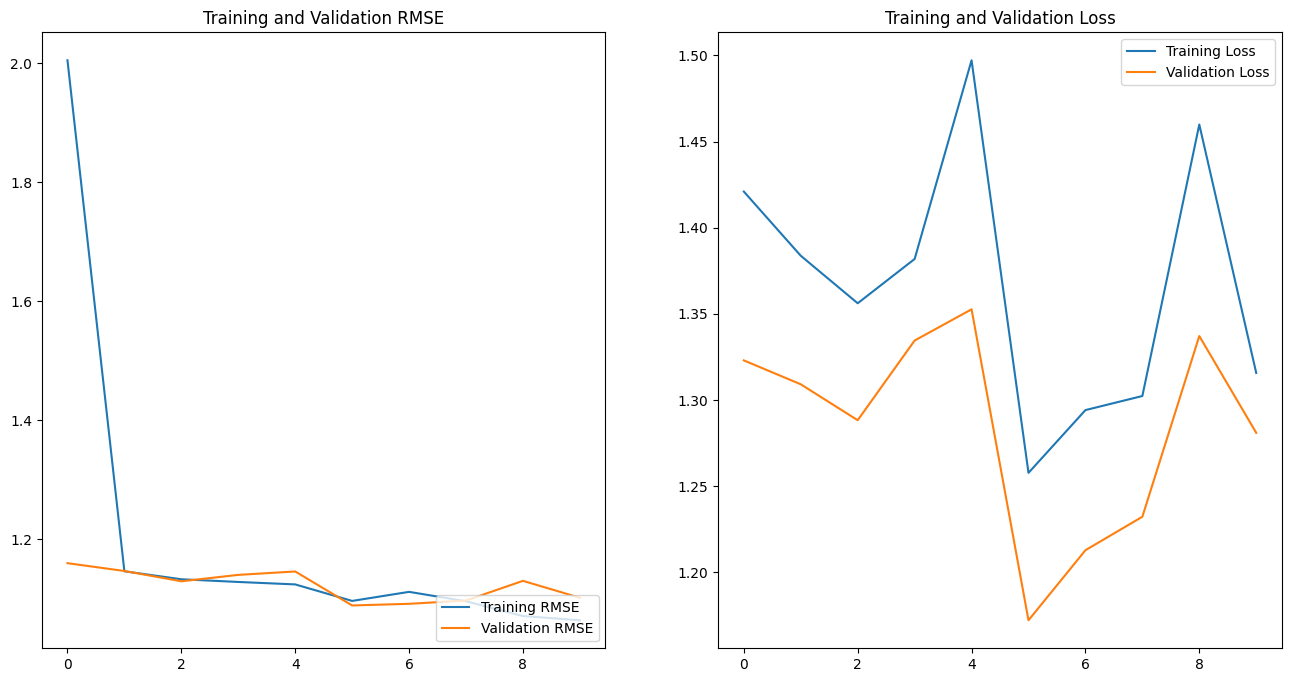

In [45]:
rmse = history.history['root_mean_squared_error']
val_rmse = history.history['val_root_mean_squared_error']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(loss))

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, rmse, label='Training RMSE')
plt.plot(epochs_range, val_rmse, label='Validation RMSE')
plt.legend(loc='lower right')
plt.title('Training and Validation RMSE')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Tune hyper parameters
Since transformer ranking model is worse than the simple model, I will tune hyper parameters on the simple model with keras tuner. I try different hidden units, embedding_dimension and learning rates.

In [ ]:
def build_tuner(hp):
    learning_rate=hp.Choice('learning_rate', [0.1, 0.01, 0.001])
    dense_units = hp.Choice('dense_units', [1024, 512, 256])
    embedding_dimension = hp.Choice('embedding_dimension', [32, 64, 128])
    model = build_model(learning_rate, dense_units, embedding_dimension)
    return model

tuner = kt.Hyperband(
    build_tuner,
    max_epochs=100,
    project_name='MovieLens',
    objective=kt.Objective("val_root_mean_squared_error", direction="min"))
tuner.search_space_summary(extended=False)
tuner.search(train_dataset, validation_data=test_dataset, epochs=30)

Trial 2 Complete [00h 00m 15s]
val_root_mean_squared_error: 1.5410223007202148

Best val_root_mean_squared_error So Far: 1.180275321006775
Total elapsed time: 00h 00m 29s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
0.01              |0.1               |learning_rate
512               |1024              |dense_units
128               |128               |embedding_dimension
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
4                 |4                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2
20/79 [======>.......................] - ETA: 9s - root_mean_squared_error: 4.1648 - loss: 17.3455 - regularization_loss: 0.0000e+00 - total_loss: 17.3455

## Conclusion
In the experiment, I train a model on Movielens dataset successful, there are some important tricks.
1. It's important to select features, useful features help improve model performance a lot, but bad features may mislead models.
2. Embeddings could tranfer inputs dimensions into target dimensions and reduce model size.
3. MLP always works as a regression head in ranknig model.

But there are still some aspects worth to explore, such as why transformer model performance is so bad, how can I improve the transformer ranking model performance and try to use classification head in the ranking model.

Here is some tips may improve simple model performance:
1. Use composable features such as user age and user occupation(student-25), etc.
2. Employ other optimizers, such as Adam, RMSProp, SGD, etc
3. Use larger embedding sizes.

The ranking model is very intereting and flexiable, so it's worth to spend time on exploring model archs.